# Exploratory Data Analysis for Hair Type Classification

**Goals of This Notebook:**
- Conduct a structured exploratory analysis of the Hair Type dataset to understand its characteristics before building any classification or clustering models

- Examine class distributions, visual variability, image statistcs, basic texture patterns that may relate to curl tightness

- These insights are the foundation to the later stages of the project: (1) training VGG16-based CNN to classify the four broad hair categories, and (2) extracting texture and curl features to explore finer curl patterned (similiar to the Andrew Walker types) emerge through unsupervised clustering

#### Note: Some cells include working notes and ideas intended for my report

In [80]:
# libraries
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import os
import matplotlib.pyplot as plt
from glob import glob


In [81]:
# random seeds

np.random.seed(42)
tf.random.set_seed(42)

# Dataset Exploration (EDA)

## Load Dataset & Inspect Metadata

- for "Dataset Description" of report

In [82]:
# download kaggle dataset
kaggle_hairtype_dataset_path = kagglehub.dataset_download('kavyasreeb/hair-type-dataset')

print("Dataset downloaded at: ", kaggle_hairtype_dataset_path )

data_dir = kaggle_hairtype_dataset_path # dataset path

Dataset downloaded at:  C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1


In [83]:
# print folder structure
print("Dataset Folder Structure: \n")

for root, dirs, files in os.walk(data_dir):
    level = root.replace(data_dir, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4  * (level + 1)

    for file in files[:5]:
        print(f"{subindent}{file}")


Dataset Folder Structure: 

1/
    data/
        curly/
            00cbad1ffe22d900018e5a2e7376daed4.jpg
            0160dfee18352aa9bf5c6e617de9e07b4.jpg
            03312ac556a7d003f7570657f80392c34.jpg
            0fd85bcde626a95e20489c83f292d8204.jpg
            1-curly-hair-with-bangs-CYFg6l_Ls4-.jpg
        dreadlocks/
            05740e64c1d611e74723ed4103776b71.jpg
            0a62ef878341056d842dbde6365f9c4a4.jpg
            0fgjhs702ob4uoi75.jpg
            1-rihanna-dreadlocks.jpg
            11-small-side-swept-dreads-CC7LDipp1aw.jpg
        kinky/
            011b913aca7afbdd7feb6cdd4481b3bf4.jpg
            037f2da43c5f2c5be1e462ca5aad1c43.jpg
            057656ef97f71b87e933f8608e3e1f7b.jpg
            07.13_blog_dry_curly_hair-1024x410.jpg
            0c371e87183918327339725daef22cb9.jpg
        Straight/
            000028d73-Nicole_Scherzinger.jpg
            01-10-2019-latest-haircut-for-girls_Equal_Length_4PNG.jpg
            01-10-2019-latest-haircut-for-girls_sho

In [84]:
data_dir = os.path.join(data_dir, "data")

# extract imgs
img_paths = glob(os.path.join(data_dir, "*", "*.jpg"))

# extract labels
labels = [os.path.basename(os.path.dirname(path)) for path in img_paths]

# dataframe
df = pd.DataFrame({
    "image_path": img_paths,
    "label": labels
})

# makes all labels lowercase
df["label"] = df["label"].str.lower()
# filter labels (dreads is not a hair type)
df = df[df["label"].isin(["straight", "wavy", "curly", "kinky"])]

# change order of classes to match type 1, 2, 3, 4 (glob makes alphabetical)
class_order = ["straight", "wavy", "curly", "kinky"]
df["label"] = pd.Categorical(df["label"], categories=class_order, ordered=True)
df = df.sort_values("label").reset_index(drop=True)

pd.set_option("display.max_colwidth", None)
df.head()

image_path  \
0  C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\11e655773616e81becaf72fba5ccf891.jpg   
1                          C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images17.jpg   
2                      C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images17 (2).jpg   
3                          C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images16.jpg   
4                         C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images159.jpg   

      label  
0  straight  
1  straight  
2  straight  
3  straight  
4  straight

## Dataset Overview

- good for Experiment Settings and Benchmark Data section of report

In [85]:
# total number of images
total_images = len(df)
print("Total images in dataset: ", total_images)

# number of images per class
img_in_class_count = df["label"].value_counts()
print("Total number of images per class:\n", img_in_class_count)

Total images in dataset:  1410
Total number of images per class:
 label
curly       478
straight    438
wavy        284
kinky       210
Name: count, dtype: int64


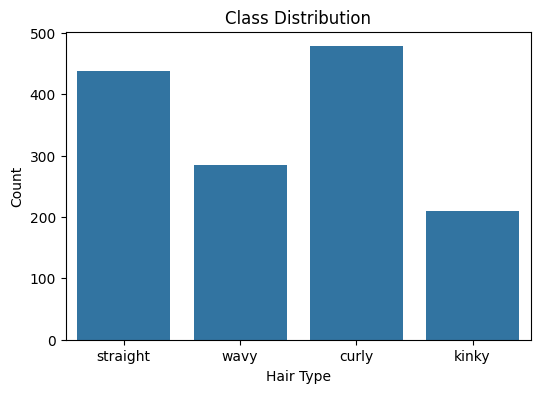

In [86]:
# bar chart visualization of class distribution # class imbalance ratio
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label')
plt.title("Class Distribution")
plt.xlabel("Hair Type")
plt.ylabel("Count")
plt.show()

## Display Sample Images

Why:
- See Data diversity
- see lighting/background issues (can be mentioned in report)
- see if curliness is visually apparent

figures would go well in report

(delete or rewrite later)

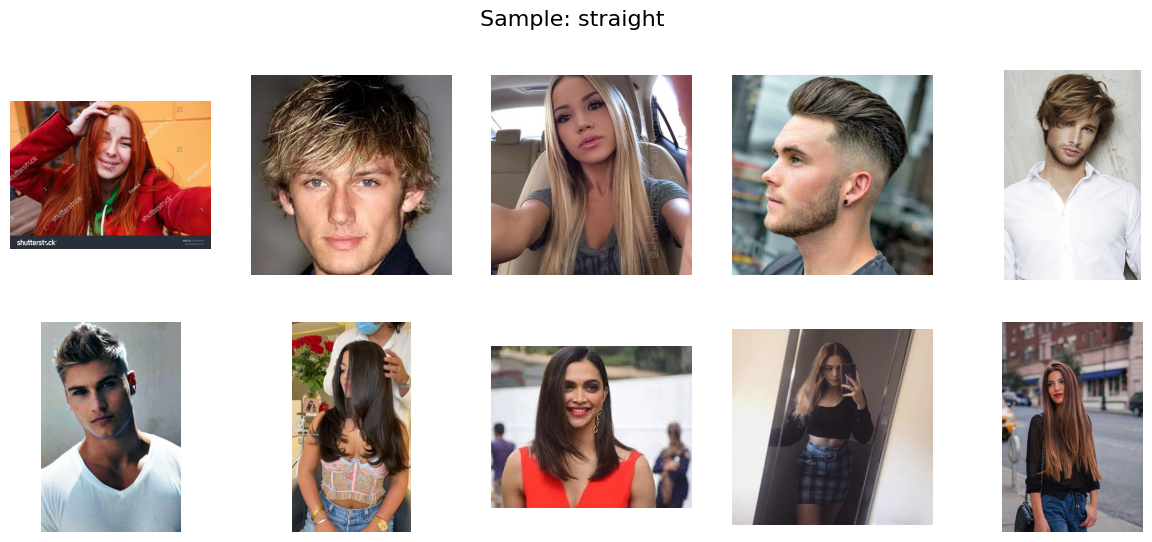

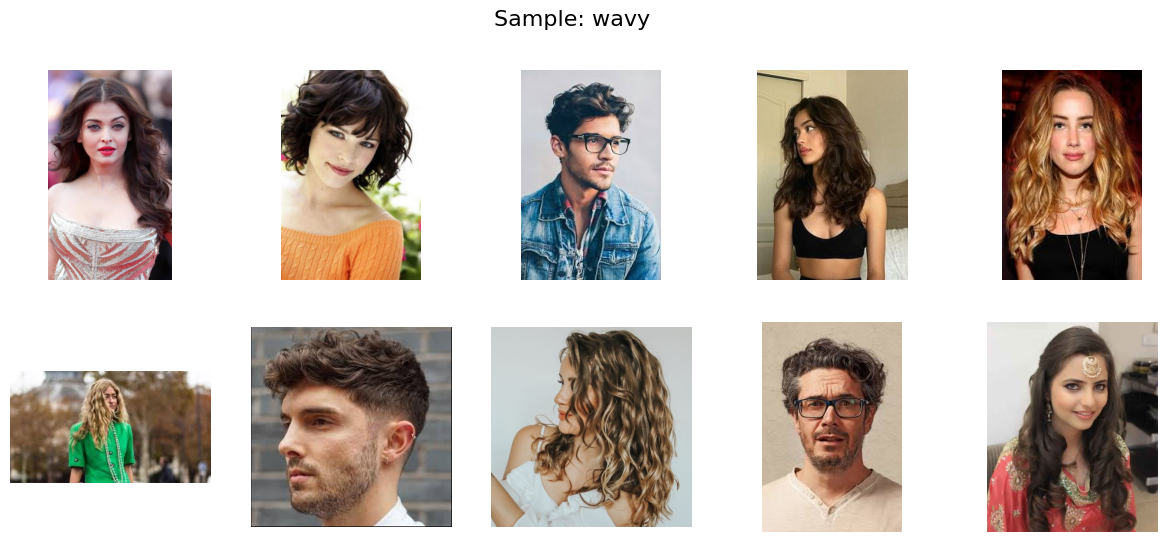

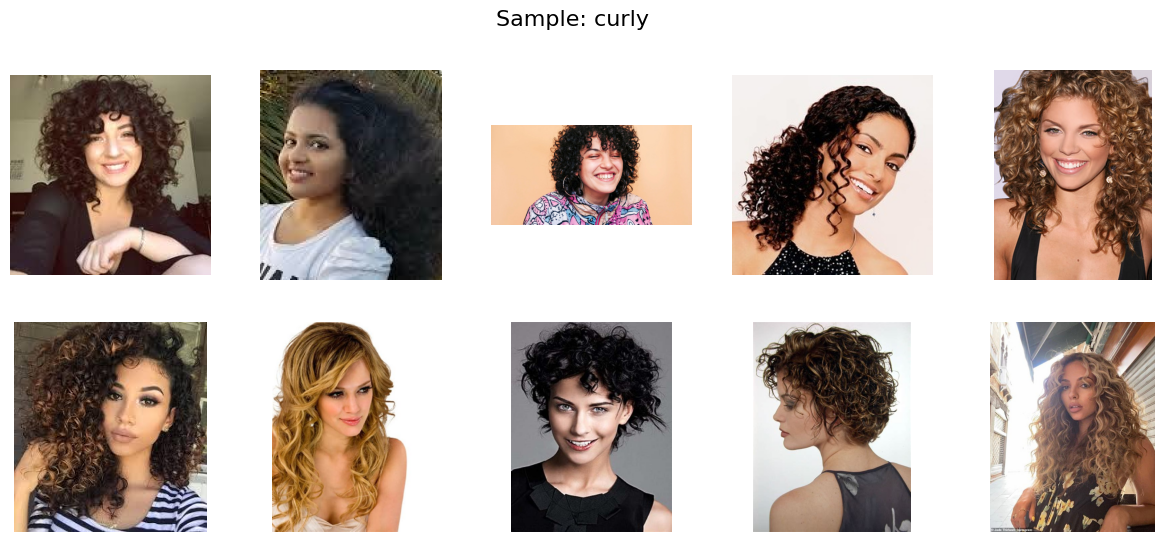

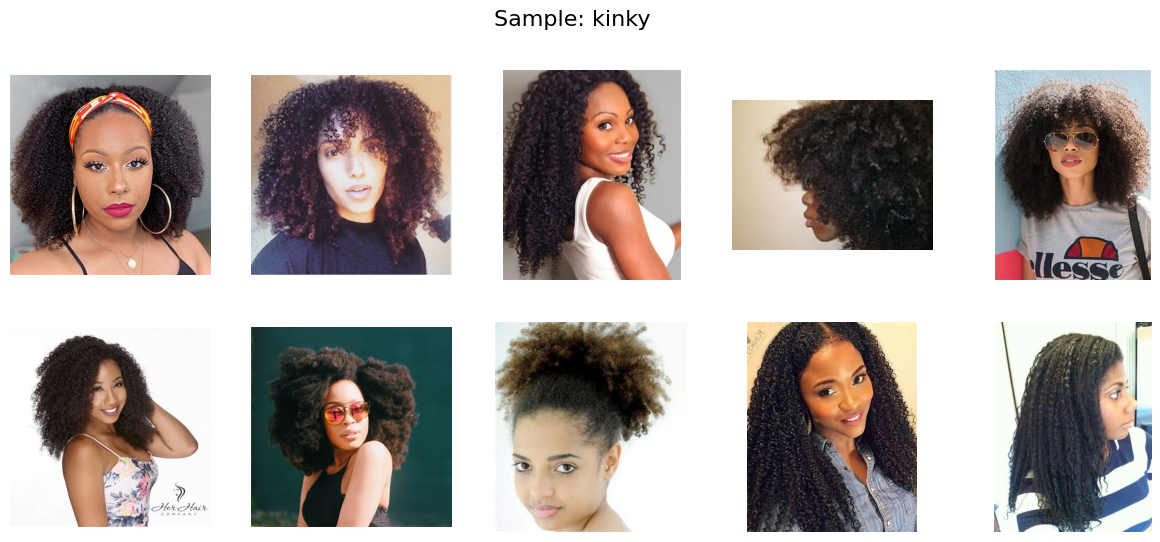

In [87]:
# display 10 images per class
import random
from PIL import Image

classes = df["label"].unique()

for label in classes:
    subset = df[df["label"] == label] # only images for the current class

    sample_paths = subset.sample(10)["image_path"].tolist()

    # figure for each class
    plt.figure(figsize=(15, 6))
    plt.suptitle(f"Sample: {label}", fontsize=16)

    for i, path in enumerate(sample_paths):
        img = Image.open(path)

        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.axis("off")

    plt.show()
    


## Image Dimensions & Aspect Ratio

- Good for justifying resizing decisions before sending images into VGG16

In [88]:
# load images

# print shapes (height, width, channels)
heights = []
widths = []
channels = []

for path in df["image_path"]:
    img = Image.open(path)
    arr = np.array(img) # convert img to array

    h, w, = arr.shape[0], arr.shape[1]

    c = arr.shape[2] if arr.ndim == 3 else 1

    heights.append(h)
    widths.append(w)
    channels.append(c)

# height, width, and channels column
df["height"] = heights
df["width"] = widths
df["channels"] = channels

df.head()




image_path  \
0  C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\11e655773616e81becaf72fba5ccf891.jpg   
1                          C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images17.jpg   
2                      C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images17 (2).jpg   
3                          C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images16.jpg   
4                         C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images159.jpg   

      label  height  width  channels  
0  straight     591    473         3  
1  straight     177    284         3  
2  straight     279    181         3  
3  straight     202    249         3  
4  straight     172    151         3

In [89]:
# count frequency of unqiue dimension

dim_counts = df.groupby(["width", "height"]).size().reset_index(name="count") # amt of imgs with same resolution
dim_counts.sort_values("count", ascending=False).head(10)

width  height  count
281    474     474     83
86     225     225     59
382    474     711     37
1      100     100     31
423    500     500     28
21     183     275     28
149    275     183     22
137    259     194     19
332    474     592     18
54     201     251     13

In [90]:
# compute aspect ratio

df["aspect_ratio"] = df["width"] / df["height"]
df["aspect_ratio"].head()

0    0.800338
1    1.604520
2    0.648746
3    1.232673
4    0.877907
Name: aspect_ratio, dtype: float64

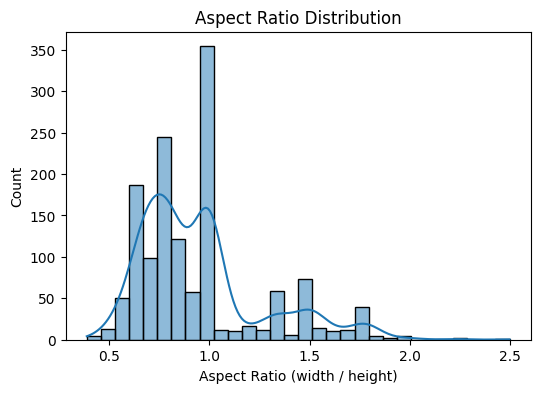

In [91]:
# visualize histogram of aspect ratios
plt.figure(figsize=(6,4))
sns.histplot(df["aspect_ratio"], bins=30, kde=True) # aspect ratio range divided into 30 chunks, show curve

plt.title("Aspect Ratio Distribution")
plt.xlabel("Aspect Ratio (width / height)")
plt.ylabel("Count")
plt.show()

## Image Statisitics (to analyze class differences for CNN)

 - Average brightness
 - Average color histograms per channel
 - hair-region pixel proportion
 
 helps answer these if want to put in report:
 - does hair type correlate with brightness or color distributions
 - do curly/kinky images have different texture intensity

good for discussing lights, color bias across classes, texture intensity diffs, and whether preprocessing is necessary

In [92]:
# compute average brightness per image
import cv2

brightness = []

for path in df["image_path"]:
    img = cv2.imread(path)
    # convert images to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    brightness.append(img_gray.mean())

df["brightness"] = brightness
df.head()

image_path  \
0  C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\11e655773616e81becaf72fba5ccf891.jpg   
1                          C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images17.jpg   
2                      C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images17 (2).jpg   
3                          C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images16.jpg   
4                         C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images159.jpg   

      label  height  width  channels  aspect_ratio  brightness  
0  straight     591    473         3      0.800338  114.276347  
1  straight     177    284         3      1.604520  200.348731  
2  straight     279    181         3      0.648746  145.681063  
3  straight     202    249         3      1.232673  157.705575  
4  straight     172    151         3      0.877907  148.798552

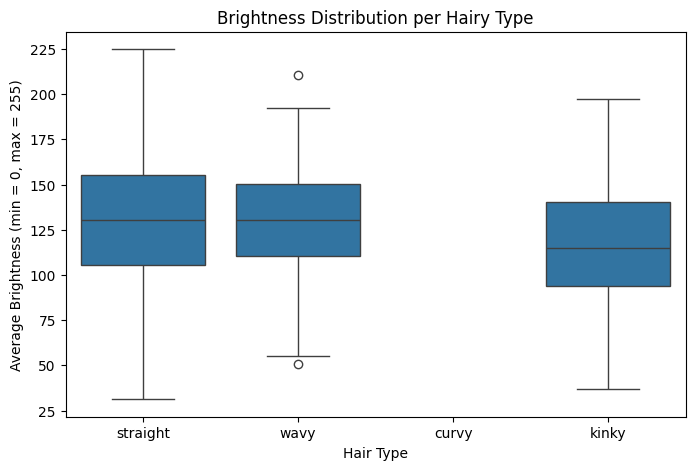

In [93]:
# plot brightness distribution per image
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="label", y="brightness", order=["straight", "wavy", "curvy", "kinky"])
plt.title("Brightness Distribution per Hairy Type")
plt.xlabel("Hair Type")
plt.ylabel("Average Brightness (min = 0, max = 255)")
plt.show()


In [94]:
# function to compute color histograms for RGB channels
def compute_color_histogram(img, bins=32):
    # img is a BGR image
    hist_B = cv2.calcHist([img], [0], None, [bins], [0, 256]).flatten()
    hist_G = cv2.calcHist([img], [1], None, [bins], [0, 256]).flatten()
    hist_R = cv2.calcHist([img], [2], None, [bins], [0, 256]).flatten()

    return hist_R, hist_G, hist_B

In [95]:
# compute color histograms for RBG channels within sample df
sample_df = (df.groupby("label").apply(lambda x: x.sample(min(len(x), 50), random_state=42)).reset_index(drop=True))
R_hists = []
G_hists = []
B_hists = []

for path in sample_df["image_path"]:
    img = cv2.imread(path)
    R, G, B = compute_color_histogram(img)
    R_hists.append(R)
    G_hists.append(G)
    B_hists.append(B)

sample_df["hist_R"] = R_hists
sample_df["hist_G"] = G_hists
sample_df["hist_B"] = B_hists

C:\Users\nisa2\AppData\Local\Temp\ipykernel_13600\4046090589.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_df = (df.groupby("label").apply(lambda x: x.sample(min(len(x), 50), random_state=42)).reset_index(drop=True))
C:\Users\nisa2\AppData\Local\Temp\ipykernel_13600\4046090589.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = (df.groupby("label").apply(lambda x: x.sample(min(len(x), 50), random_state=42)).reset_index(drop=True))


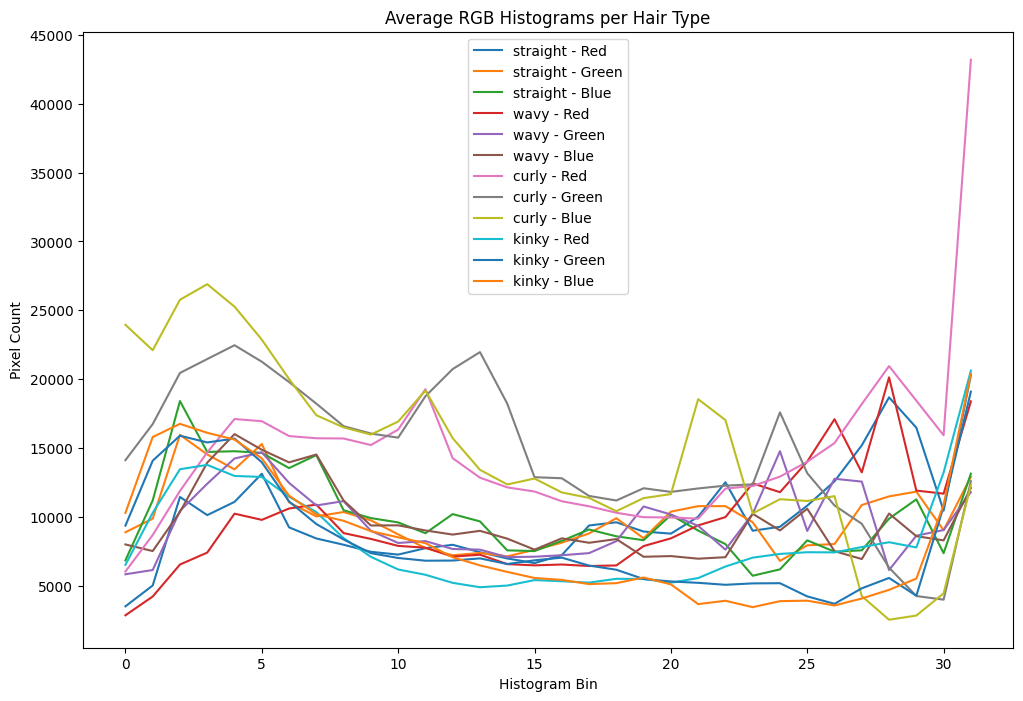

In [97]:
bins = np.arange(32)

plt.figure(figsize=(12, 8))

for label in ["straight", "wavy", "curly", "kinky"]:
    subset = sample_df[sample_df["label"] == label]

    # compute average histograms 
    avg_R = np.mean(np.vstack(subset["hist_R"].values), axis=0)
    avg_G = np.mean(np.vstack(subset["hist_G"].values), axis=0)
    avg_B = np.mean(np.vstack(subset["hist_B"].values), axis=0)

    # plot the channel curves
    plt.plot(bins, avg_R, label=f"{label} - Red")
    plt.plot(bins, avg_G, label=f"{label} - Green")
    plt.plot(bins, avg_B, label=f"{label} - Blue")

plt.title("Average RGB Histograms per Hair Type")
plt.xlabel("Histogram Bin")
plt.ylabel("Pixel Count")
plt.legend()
plt.show()

## Edge Detection Exploration

This is an insight into hair texture

Insight goals:
- curly and kinky hair have more edges
- straight hair have smoother regions

-- this supports reasoning for feature extraction and curl tightness

In [107]:
# function to count the number of edges

def count_edges(path, low=50, high=150):
    img = cv2.imread(path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # edge detector
    edges = cv2.Canny(img_gray, threshold1=low, threshold2=high)

    # Count edge pixels (white pixels = 255)
    num_edges = np.sum(edges > 0)

    return num_edges


In [108]:
# apply Canny edge detection on sample images
edge_df = df.copy()
edge_df["edge_count"] = edge_df["image_path"].apply(count_edges)

edge_df.head()

image_path  \
0  C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\11e655773616e81becaf72fba5ccf891.jpg   
1                          C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images17.jpg   
2                      C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images17 (2).jpg   
3                          C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images16.jpg   
4                         C:\Users\nisa2\.cache\kagglehub\datasets\kavyasreeb\hair-type-dataset\versions\1\data\Straight\images159.jpg   

      label  height  width  channels  aspect_ratio  brightness  edge_count  
0  straight     591    473         3      0.800338  114.276347       43235  
1  straight     177    284         3      1.604520  200.348731        1255  
2  straight     279    181         3      0.648746  145.681063        6804  
3  straight     202    249         3      1.232673  157.705575        1192  
4  straight     172    151         3      0.877907  148.798552        4156

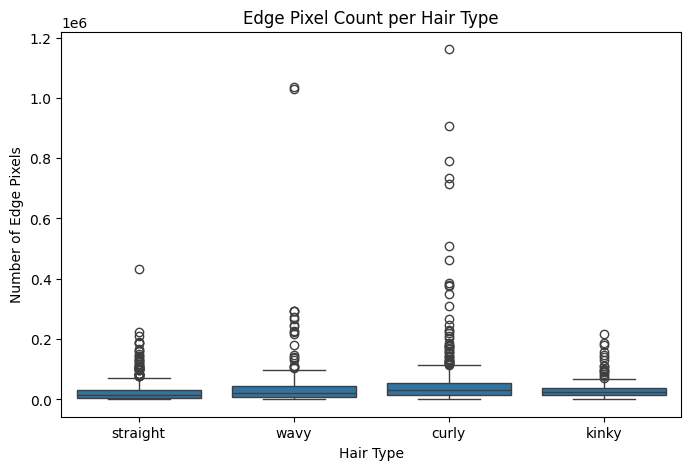

In [109]:
# plot number of edge pixels per class

plt.figure(figsize=(8,5))
sns.boxplot(data=edge_df, x="label", y="edge_count", order=["straight", "wavy", "curly", "kinky"])

plt.title("Edge Pixel Count per Hair Type")
plt.xlabel("Hair Type")
plt.ylabel("Number of Edge Pixels")
plt.show()

I would like to point out that kinky hair is surprisingly a lot less edge detection as aspected. As expected there was higher edge detection the curlier the hair, however kinky ended up as low as straight. I believe this is due to kinky hair have an extremely dense microtexture with many tiny features. There may also fewer gradients detected and fewer pixels passing the threshold since the kinky hair is typically dark and dark hard on a dark background can make edge count appear low.

lets look at texture exploration. I believe Canny might not be the best for detecting tight curls that are dense. 

this shows that edge detection alone fails for microdense texture. Therefore we need better texture descriptors. -- for the paper this will help justify the texture extraction

## Texture Feature Exploration

-- to show why texture matters and motivate feature extraction
-- this is superior to just Canny edge detection

### Gabor Filter
- show frequency and orietation patterns
---- curly texture produce unique responses

hair curl patterns should naturally produce directional textures

Straight hair should be strong responses only as specific orientations
Wavy hair should be moderate, periodic patterns
Curly hair should have higher frequency repeated curves
Kinky hair should have dense high-frequency textures in multiple orientation

In [125]:
# function to apply Gabor filters at multple orientations
def apply_gabor_filters(img, ksize=35): #ksize 31 for broader textures
    gabor_responses = []
    # convert images to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # the orientation in radians
    orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 0 degrees, 45 degrees, 90 degrees, 135 degrees

    for theta in orientations:
        # NOTE: smaller lambd helps for tighter curls, larger lambd helps for looser curls
        # parameters were lightly tuned to produce interpretable texture responses for different hair types
        kernel = cv2.getGaborKernel((ksize, ksize), sigma=5.0, theta=theta, lambd=10.0, gamma=0.5, psi=0)  
        filtered = cv2.filter2D(img_gray, cv2.CV_8UC3, kernel)
        filtered = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX) # normalized to improve visibility
        gabor_responses.append(filtered)
    return gabor_responses

In [141]:
# get sharpness of image
def estimate_sharpness(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return 0.0
    lap = cv2.Laplacian(img, cv2.CV_64F)
    return lap.var()

C:\Users\nisa2\AppData\Local\Temp\ipykernel_13600\256246504.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  example_df = df.groupby("label").head(1)


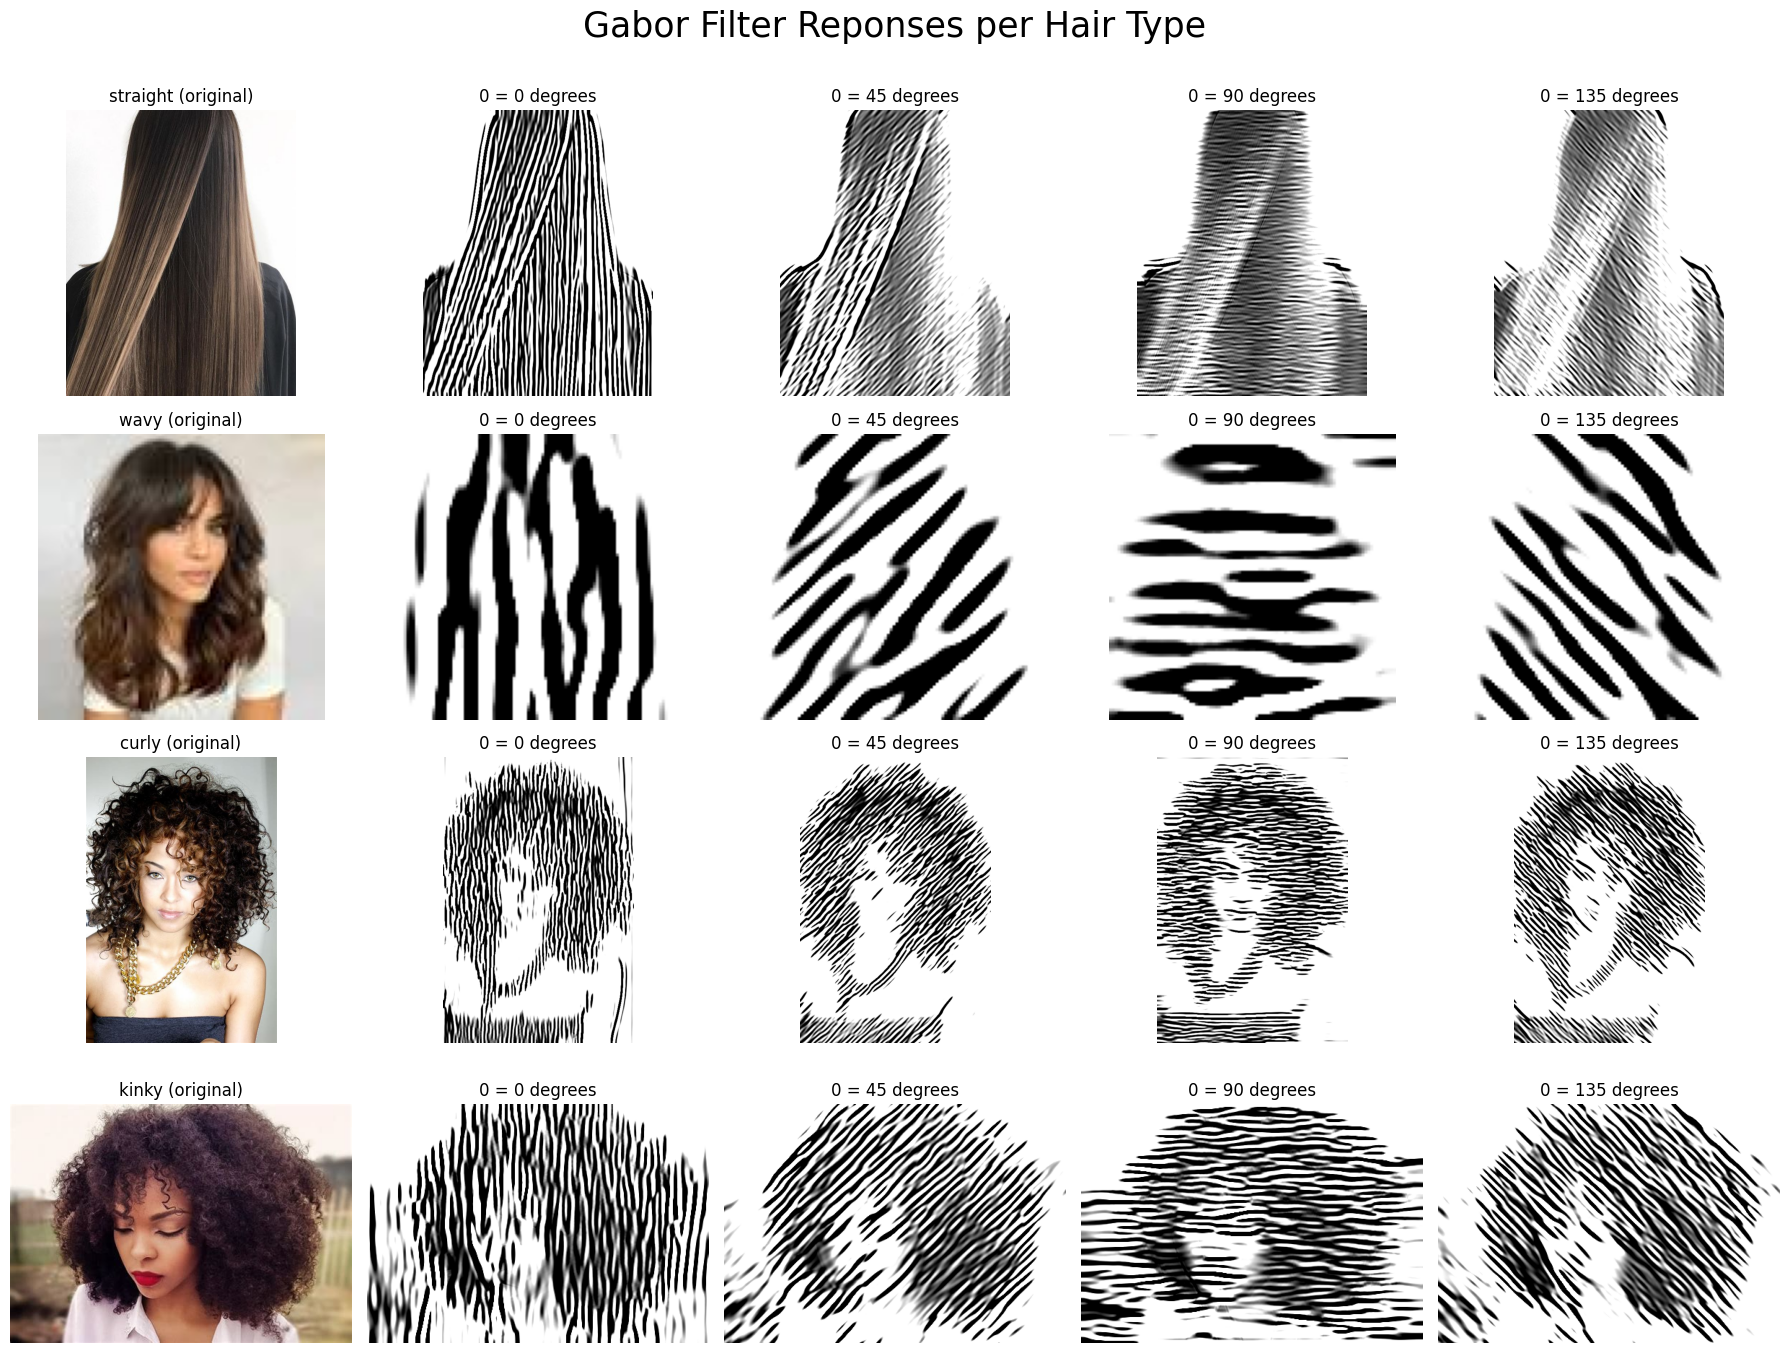

In [144]:
# show frequency and orientation patterns

# using one example from each class
example_df = df.groupby("label").head(1)
example_paths = example_df["image_path"].tolist()
example_labels = example_df["label"].tolist()

orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 0 degrees, 45 degrees, 90 degrees, 135 degrees

# plot
plt.figure(figsize=(18, 14))

for idx, (path, label) in enumerate(zip(example_paths, example_labels)):
    img = cv2.imread(path)

    # original image
    plt.subplot(len(example_paths), 5, idx*5 + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{label} (original)")
    plt.axis("off")

    gabor_responses = apply_gabor_filters(img) # applying gabor filters on image

    # 4 orientations
    for i, (resp, theta) in enumerate(zip(gabor_responses, orientations)):
        plt.subplot(len(example_paths), 5, idx*5 + i + 2)
        plt.imshow(resp, cmap="gray")
        plt.title(f"0 = {int(np.degrees(theta))} degrees")
        plt.axis("off")

plt.suptitle("Gabor Filter Reponses per Hair Type", fontsize=25)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()
        

Insights:
Straight - has overlapping strand highlights, strong vertical and diagonal frequencies
Wavy - has consistant large scale wave orientation, filter produces think diagonal or horizaontal stripes (may be also due to image sharpness)
curly - has high frequency, circulat microtexture, filters produces dense speckles
kinky - has very dense microtexture but also has dark regions. filter misses part to create odd perrters

### Local Binary Patterns
- lbp is good for strand texture
- you can see how this can detect tighter curls better

In [147]:
pip install scikit-image==0.21.0

   ---------------------------------------- 0.0/22.8 MB ? eta -:--:--
   ---- ----------------------------------- 2.6/22.8 MB 13.7 MB/s eta 0:00:02
   --------- ------------------------------ 5.2/22.8 MB 12.7 MB/s eta 0:00:02
   ------------- -------------------------- 7.9/22.8 MB 12.8 MB/s eta 0:00:02
   ------------------ --------------------- 10.7/22.8 MB 12.9 MB/s eta 0:00:01
   ----------------------- ---------------- 13.4/22.8 MB 12.7 MB/s eta 0:00:01
   ---------------------------- ----------- 16.3/22.8 MB 13.0 MB/s eta 0:00:01
   --------------------------------- ------ 19.1/22.8 MB 13.1 MB/s eta 0:00:01
   -------------------------------------- - 22.0/22.8 MB 13.0 MB/s eta 0:00:01
   ---------------------------------------- 22.8/22.8 MB 12.5 MB/s  0:00:01
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 1.7/1.7 MB 10.4 MB/s  0:00:00
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ----------

In [148]:
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

In [149]:
# LBP function
# compute local binary pattern for BGR IMAGE. 

def compute_LBP(img, P=8, R=1):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    LBP = local_binary_pattern(gray_img, P, R, method="uniform")
    return LBP # return lbp img

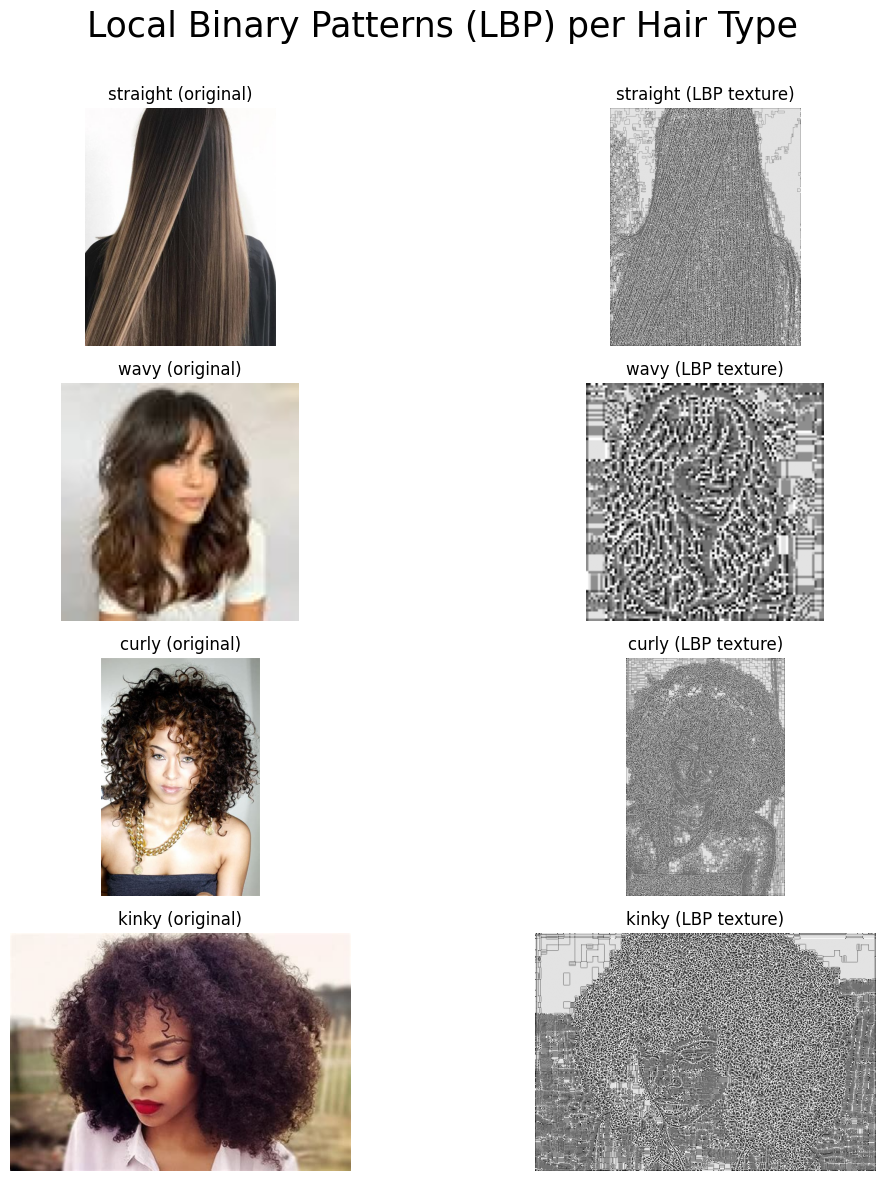

In [152]:
# plot LBP results

plt.figure(figsize=(12, 12))

for idx, (path, label) in enumerate(zip(example_paths, example_labels)):
    img = cv2.imread(path)

    # original
    plt.subplot(len(example_paths), 2, idx*2 + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"{label} (original)")
    plt.axis("off")

    # compute LBP
    LBP = compute_LBP(img)

    # LBP
    plt.subplot(len(example_paths), 2, idx*2 + 2)
    plt.imshow(LBP, cmap="gray")
    plt.title(f"{label} (LBP texture)")
    plt.axis("off")

plt.suptitle("Local Binary Patterns (LBP) per Hair Type", fontsize=25)
plt.tight_layout(rect=[0,0,1,0.97])
plt.show()

    

Insights:
Straight - smooth, low-frequency, fairy uniform, long streaks, low variation
Wavy - medium variation,  more disruptions than straight, still somewhat smooth, patterns more directional
curly - dense local transitions, many local changes, looks speckled or peppery, texture complexity increases
kinky -extremely high frequency, very very dense,  more speckled almost like static noise, 

**LBP Histogram to get quantative**

In [157]:
# function to get lbp histogram
def LBP_histogram(LBP, P=8):
    bins = np.arange(0, P+3)
    hist, _ = np.histogram(LBP.ravel(), bins=bins, density=True)
    return hist # return normalized histogram with values that sum to 1

In [162]:
# compute LBP histograms for all images
LBP_features = []

for path in df["image_path"]:
    img = cv2.imread(path)
    LBP = compute_LBP(img)
    hist = LBP_histogram(LBP)
    LBP_features.append(hist)

df_LBP = df.copy()
df_LBP["LBP_hist"] = LBP_features

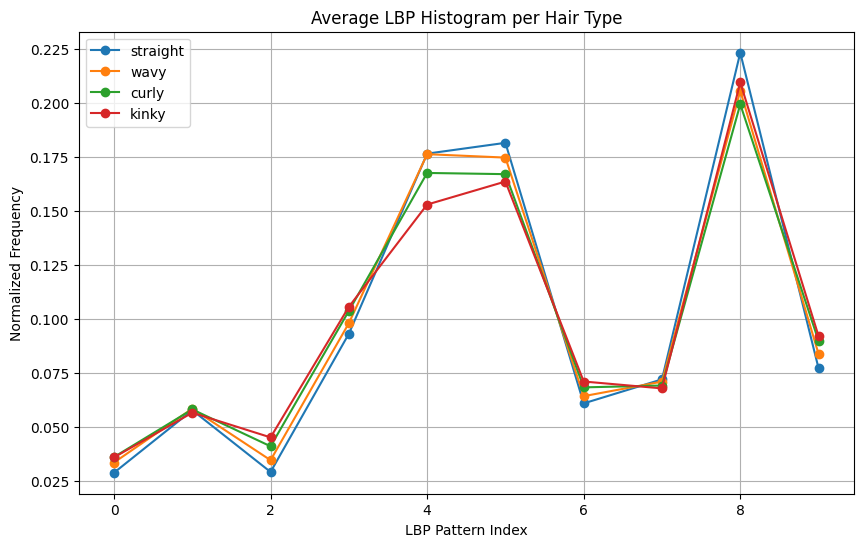

In [166]:
# plot average LBP histogram

num_bins = df_LBP["LBP_hist"].iloc[0].shape[0]
bins = np.arange(num_bins)

plt.figure(figsize=(10, 6))

for label in ["straight", "wavy", "curly", "kinky"]:
    subset = df_LBP[df_LBP["label"] == label]["LBP_hist"]

    # avg histograms for class
    avg_hist = np.mean(np.vstack(subset.values), axis=0)

    plt.plot(bins, avg_hist, marker="o", label=label)

plt.xlabel("LBP Pattern Index")
plt.ylabel("Normalized Frequency")
plt.title("Average LBP Histogram per Hair Type")
plt.legend()
plt.grid(True)
plt.show()

the hair types share simliar low-level local texture patterns. 
they differ in frequency distribution
straight hair has lower counter in mid-complexity pattersn, while kinky has higher frequencies of complex patterns. 

### GLCM Metrics
- contrast, homogeneity, energy, entropy

In [169]:
from skimage.feature import graycomatrix, graycoprops

In [174]:
# function to compute GLCM contrast, homogeneity, energy, and entropy

def compute_GLCM_features(img):
    # gray scale img
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # reduce to 32 gray levels
    gray_img_reduced = (gray_img / 8).astype('uint8')

    distances = [1] # 1 pixel
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 0, 45, 90, 135

    GLCM = graycomatrix(gray_img_reduced, distances=distances, angles=angles, symmetric=True, normed=True)

    # extract fields
    contrast = graycoprops(GLCM, 'contrast').mean()
    energy = graycoprops(GLCM, 'energy').mean()
    homogeneity = graycoprops(GLCM, 'homogeneity').mean()

    # compute entropy
    GLCM_vals = GLCM[:, :, 0, :] # shape (32, 32 4)
    entropy = -np.sum(GLCM_vals * np.log2(GLCM_vals + 1e-10)) / 4

    return contrast, energy, homogeneity, entropy
    

In [175]:
# compute metrics for sample

sample_GLCM_df = df.groupby("label").head(50).copy()

GLCM_features = []

for path in sample_GLCM_df["image_path"]:
    img = cv2.imread(path)
    contrast, energy, homogeneity, entropy = compute_GLCM_features(img)
    GLCM_features.append([contrast, energy, homogeneity, entropy])

sample_GLCM_df[["contrast", "energy", "homogeneity", "entropy"]] = GLCM_features

C:\Users\nisa2\AppData\Local\Temp\ipykernel_13600\3512426521.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_GLCM_df = df.groupby("label").head(50).copy()


C:\Users\nisa2\AppData\Local\Temp\ipykernel_13600\668811940.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sample_GLCM_df, x="label", y=metric, palette="Set2")
C:\Users\nisa2\AppData\Local\Temp\ipykernel_13600\668811940.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sample_GLCM_df, x="label", y=metric, palette="Set2")
C:\Users\nisa2\AppData\Local\Temp\ipykernel_13600\668811940.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=sample_GLCM_df, x="label", y=metric, palette="Set2")
C:\Users\nisa2\AppData\Local\Temp\ipy

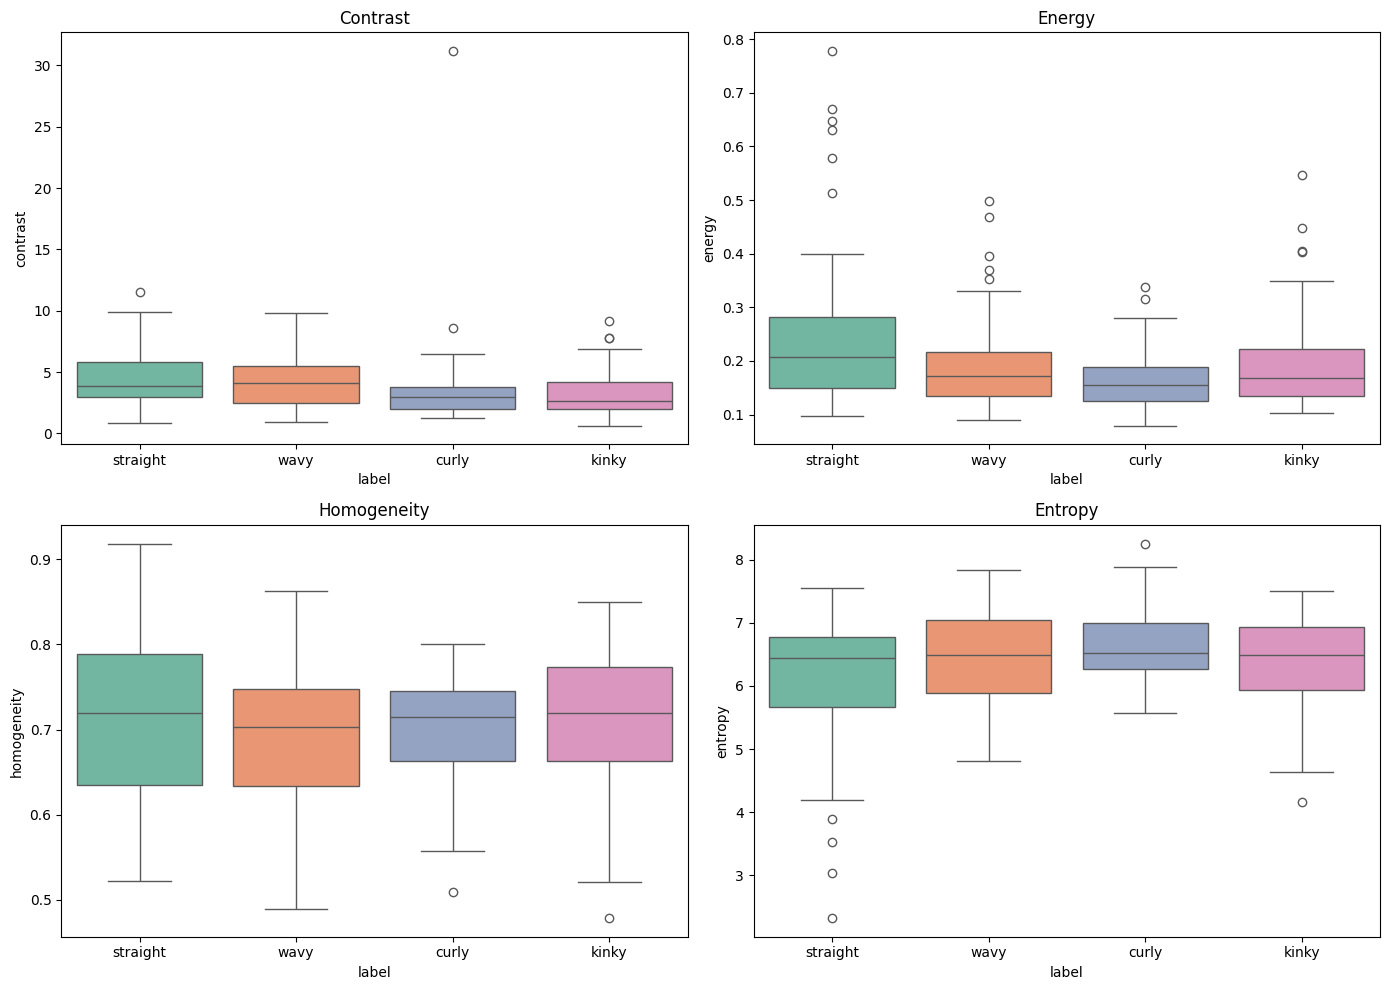

In [177]:
# plot the metrics

metrics = ["contrast", "energy", "homogeneity", "entropy"]

plt.figure(figsize=(14, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.boxplot(data=sample_GLCM_df, x="label", y=metric, palette="Set2")
    plt.title(metric.capitalize())

plt.tight_layout()
plt.show()

Insights:
progression of texture complexity across all hair types 
contast increases, energy and homogeneity decrease, and entropy rises from straight to wavy, to curly, to kinky

## Feature DataFrame Preview

-- 40 random images for preview

image       label          curl_tightness        glcm contrast         density

-- for technical details

## Dimentionality Reduction Preview


-- this will help prove that there is a possiblilty what i will do will work

-- can show sepraretion between classes and potential subclutsters within images

In [ ]:
# run PCA on preview dataset

In [ ]:
# plot points colors by class (straight, wavy, curly, kinky)

## Prepare Data for Classification (VGG16)

In [ ]:
# image resize size

In [ ]:
# train, val, and test split paths

In [ ]:
# preprocess input